### Welcome to ML4D BroadE!
We explore machine learning on Bio medical data using Cloud computing, Python, Tensorflow, and the ML4CVD codebase.

We will start with linear regression.  Our model is a vector, one weight for each input feature, and a single bias weight.

\begin{equation}
y = xw + b
\end{equation}

For notational convenience absorb the bias term into the weight vector by adding a 1 to the input data matrix X

\begin{equation}
y = [1, x][b, w]^T
\end{equation}

In [1]:
import os
import h5py
import numpy as np
from typing import List, Dict, Callable
from collections import defaultdict, Counter

# Import:
import os
import sys
import gzip
import pickle
import random

import pydicom
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

from keras import metrics
from keras.models import Sequential
from keras.layers.core import Dense

from ml4cvd.arguments import _get_tmap
from ml4cvd.TensorMap import TensorMap

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [2]:
def linear_regression():
    samples = 40
    real_weight = 2.0
    real_bias = 0.5
    x = np.linspace(-1, 1, samples)
    y = real_weight*x + real_bias + (np.random.randn(*x.shape) * 0.1)

    linear_model = Sequential()
    linear_model.add(Dense(1, input_dim=1))
    linear_model.compile(loss='mse', optimizer='sgd')
    linear_model.summary()
    linear_model.fit(x, y, batch_size=1, epochs=10)

    learned_slope = linear_model.get_weights()[0][0][0]
    learned_bias = linear_model.get_weights()[1][0]
    print('Learned slope:',  learned_slope, 'real slope:', real_weight, 'learned bias:', learned_bias, 'real bias:', real_bias)

    plt.plot(x, y)
    plt.plot([-1,1], [-learned_slope+learned_bias, learned_slope+learned_bias], 'r')
    plt.show()
    print('Linear Regression complete!')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
40/40 [==============================] - 5s 115ms/step - loss: 1.0753
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.5654
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.3147
Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.1801
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.1061
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.0646
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 8/10
40/40 [==============================] - 0s 2ms/step - loss: 0.0283
Epoch 9/10
40/40 [==

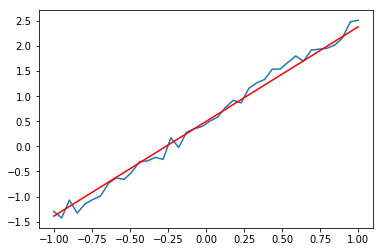

Linear Regression complete!


In [3]:
linear_regression()

## Now Logistic Regression:
We take the real-valued predictions from linear regression and squish them with a sigmoid.

\begin{equation}
\textbf{y} = \sigma(X\textbf{w} + b)
\end{equation}

where 
\begin{equation}
\sigma(x) = \frac{e^x}{1+e^x} = \frac{1}{1+e^{-x}}
\end{equation}

In [4]:
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(math.exp(item)/(1+math.exp(item)))
    return a

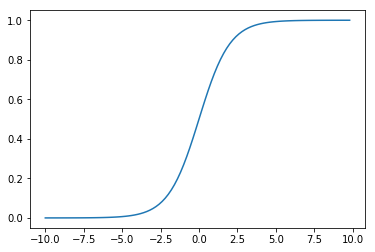

In [5]:
x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x,sig)
plt.show()

In [6]:
def logistic_regression():
	train, test, valid = load_data('mnist.pkl.gz')

	epochs = 1000
	num_labels = 10
	train_y = make_one_hot(train[1], num_labels)
	valid_y = make_one_hot(valid[1], num_labels)
	test_y = make_one_hot(test[1], num_labels)

	logistic_model = Sequential()
	logistic_model.add(Dense(10, activation='softmax', input_dim=784, name='mnist_templates'))
	logistic_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
	logistic_model.summary()
	templates = logistic_model.layers[0].get_weights()[0]
	plot_templates(templates, 0)
	print('weights shape:', templates.shape)

	for e in range(epochs):
		trainidx = random.sample(range(0, train[0].shape[0]), 8192)
		x_batch = train[0][trainidx,:]
		y_batch = train_y[trainidx]
		logistic_model.train_on_batch(x_batch, y_batch)
		if e % 100 == 0:
			plot_templates(logistic_model.layers[0].get_weights()[0], e)
			print('Logistic Model test set loss and accuracy:', logistic_model.evaluate(test[0], test_y), 'at epoch', e)


def plot_templates(templates, epoch):
	n = 10
	templates = templates.reshape((28,28,n))
	plt.figure(figsize=(16, 8))
	for i in range(n):
		ax = plt.subplot(2, 5, i+1)		
		plt.imshow(templates[:, :, i])
		plt.gray()
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)

	plot_name = "./regression_example/mnist_templates_"+str(epoch)+".png"
	if not os.path.exists(os.path.dirname(plot_name)):
		os.makedirs(os.path.dirname(plot_name))		
	plt.savefig(plot_name)


def make_one_hot(y, num_labels):
	ohy = np.zeros((len(y), num_labels))
	for i in range(0, len(y)):
		ohy[i][y[i]] = 1.0
	return ohy


def load_data(dataset):
	''' Loads the dataset
	:type dataset: string
	:param dataset: the path to the dataset (here MNIST)
	'''

	#############
	# LOAD DATA #
	#############

	# Download the MNIST dataset if it is not present
	data_dir, data_file = os.path.split(dataset)
	if data_dir == "" and not os.path.isfile(dataset):
		# Check if dataset is in the data directory.
		new_path = os.path.join("data", dataset)
		if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
			dataset = new_path

	if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
		from urllib.request import urlretrieve
		origin = (
			'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
		)
		print('Downloading data from %s' % origin)
		if not os.path.exists(os.path.dirname(dataset)):
			os.makedirs(os.path.dirname(dataset))	
		urlretrieve(origin, dataset)

	print('loading data...')

	# Load the dataset
	f = gzip.open(dataset, 'rb')
	if sys.version_info[0] == 3:
		u = pickle._Unpickler(f)
		u.encoding = 'latin1'
		train_set, valid_set, test_set = u.load()
	else:
		train_set, valid_set, test_set = pickle.load(f)

	f.close()
	#train_set, valid_set, test_set format: tuple(input, target)
	#input is an numpy.ndarray of 2 dimensions (a matrix)
	#which row's correspond to an example. target is a
	#numpy.ndarray of 1 dimensions (vector)) that have the same length as
	#the number of rows in the input. It should give the target
	#target to the example with the same index in the input.

	return train_set, valid_set, test_set

## Cross Entropy Loss:
Our favorite loss function for categorical data.
\begin{equation}
L(true, model) = -\sum_{x\in\mathcal{X}} true(x)\, \log model(x)
\end{equation}

Binary cross entropy with $N$ data points $x$ each with a binary label: 
\begin{equation}
true(x) \in \{0, 1\} \\
L(true, model) = -\frac{1}{N}\sum^N_{i=1} true(x_i)\log(model(x_i)) + (1-true(x_i))log(1-model(x_i))
\end{equation}

This is the Kullback Leibler divergence between the true distribution and the predicted. 
This function emerges in many fields as diverse as probability, information theory, and physics.
What is the information difference between the truth and our model?  How much data do I lose by replacing the truth with the model's predictions. What is the temperature difference between my predictions and the truth?!

Categorical cross entropy with $K$ different classes or labels: 
\begin{equation}
true(x) \in \{0, 1, 2, ..., K\} \\
L(true, model) = -\frac{1}{N}\sum^N_{i=1}\sum^K_{j=1} y_{ik}\log(q_k(x_i)))
\end{equation}

loading data...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist_templates (Dense)      (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
weights shape: (784, 10)
10000/10000 [==============================] - 0s 42us/step
Logistic Model test set loss and accuracy: [2.483477196121216, 0.0772] at epoch 0
10000/10000 [==============================] - 0s 38us/step
Logistic Model test set loss and accuracy: [1.6379679027557372, 0.6589] at epoch 100
10000/10000 [==============================] - 0s 38us/step
Logistic Model test set loss and accuracy: [1.2253220737457275, 0.7852] at epoch 200
10000/10000 [==============================] - 0s 38us/step
Logistic Model test set loss and accuracy: [1.0026916637420655, 0.8216] at epoch 300
10000/10000 [===============

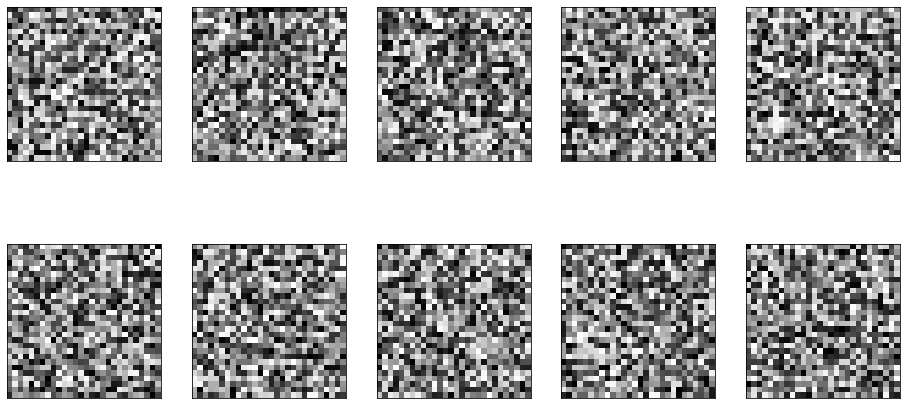

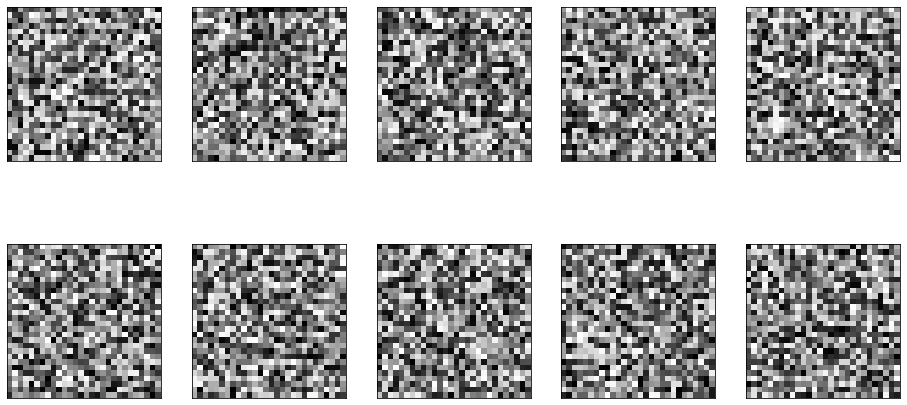

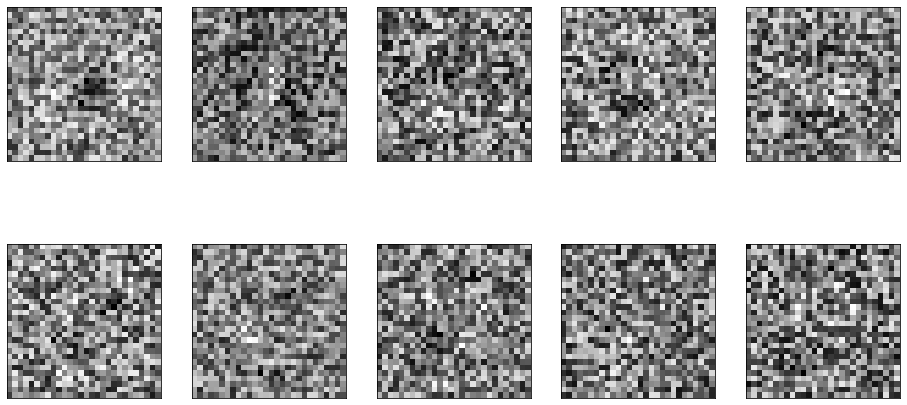

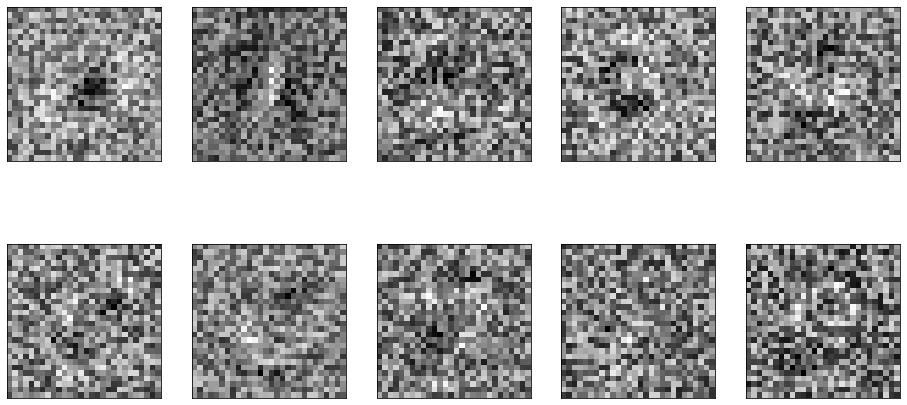

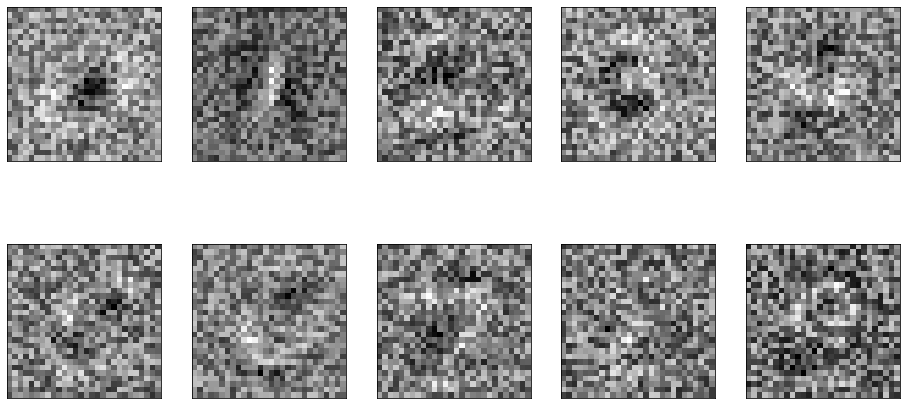

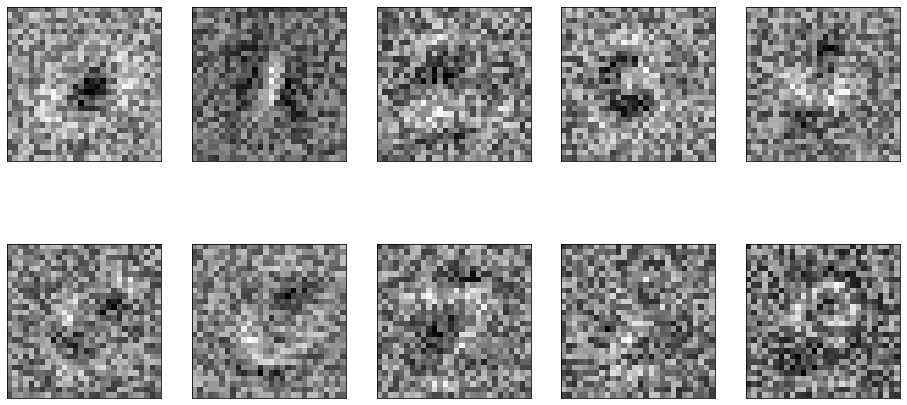

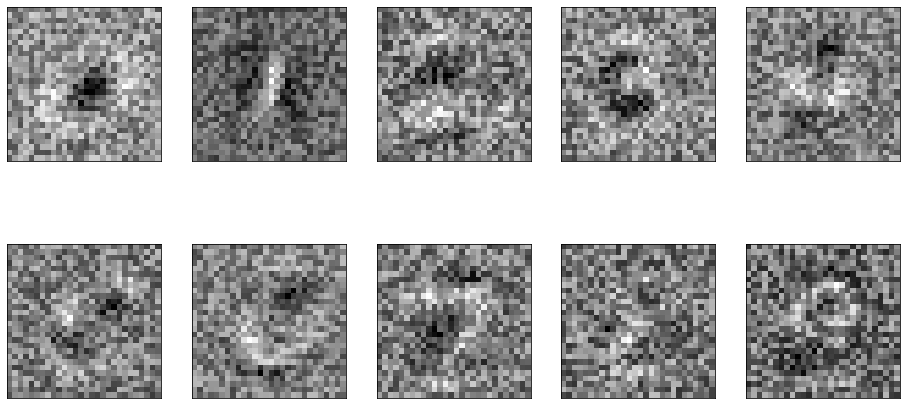

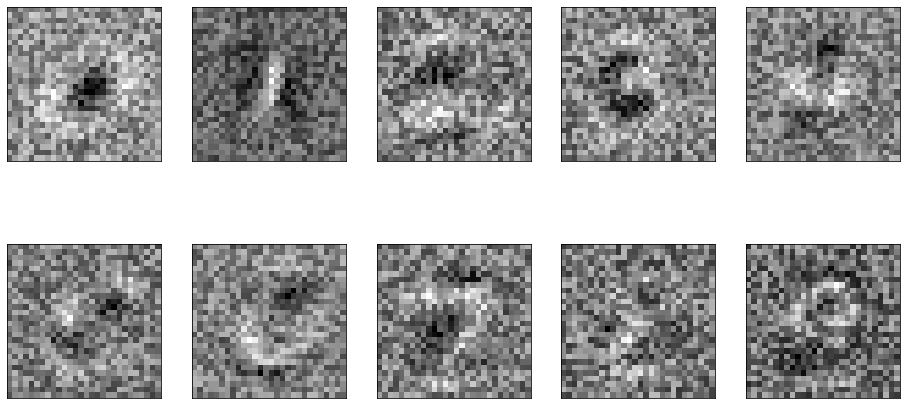

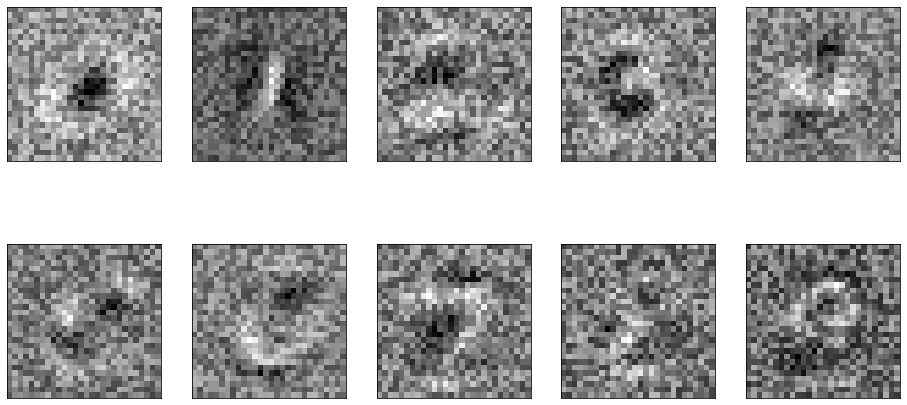

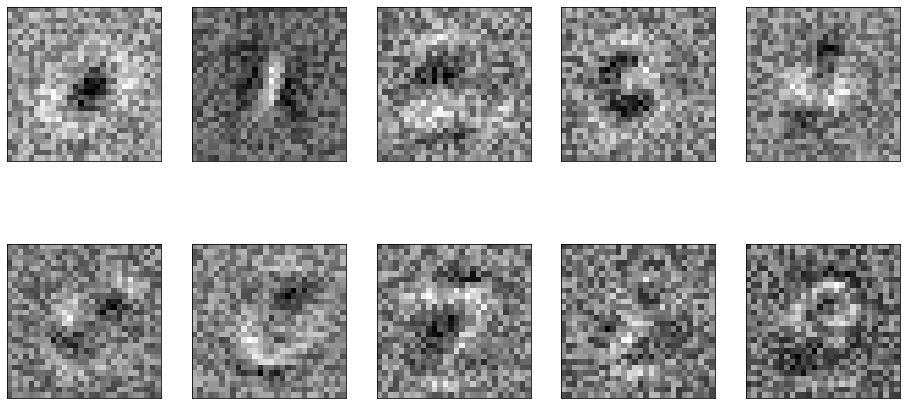

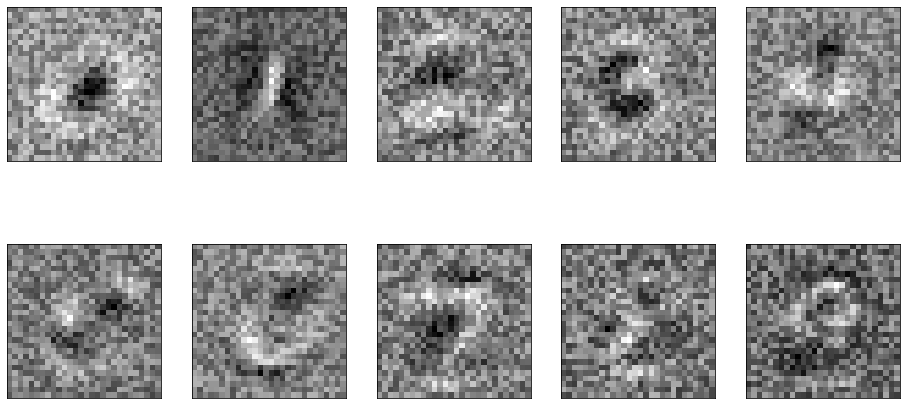

In [9]:
logistic_regression()

## TensorMaps
The critical data structure in the ML4CVD codebase is the TensorMap.
This abstraction provides a way to translate ***any*** kind of input data, into structured numeric tensors with clear semantics for interpretation and modeling.

## The Model Factory
The function ***make_multimodal_multitask_model()*** takes lists of TensorMaps and connects them with intelligent goo.

## Tensorization
Is the process of gathering any number of input files and consolidating them into compressed HD5 files.  We tend to make one HD5 file per sample in the study.  The files contain the raw data and labels we will use to train models.  It tends to be efficient to separate tensor construction from model training.

In [2]:
!mkdir ./dcm_scratch
!rm -rf ./dcm_scratch/*
!cp /home/sam/cq500/CQ500-CT-0.zip ./dcm_scratch/
!unzip ./dcm_scratch/CQ500-CT-0.zip -d ./dcm_scratch/

mkdir: cannot create directory './dcm_scratch': File exists
Archive:  ./dcm_scratch/CQ500-CT-0.zip
Created by Orthanc
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000000.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000001.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000002.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000003.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000004.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000005.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000006.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000007.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000008.dcm  


  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000082.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000083.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000084.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000085.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000086.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000087.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000088.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000089.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000090.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000091.dcm  
  inflating: ./dcm_s

  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000166.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000167.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000168.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000169.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000170.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000171.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000172.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000173.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000174.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on/CT000175.dcm  
  inflating: ./dcm_s

  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000035.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000036.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000037.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000038.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000039.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000040.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000041.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000042.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000043.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000044.dcm  


  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000117.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000118.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000119.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000120.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000121.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000122.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000123.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000124.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000125.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000126.dcm  


  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000199.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000200.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000201.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000202.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000203.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000204.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000205.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000206.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000207.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-2/CT000208.dcm  


  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000042.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000043.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000044.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000045.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000046.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000047.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000048.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000049.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000050.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000051.dcm  


  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000126.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000127.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000128.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000129.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000130.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000131.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000132.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000133.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000134.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000135.dcm  


  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000207.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000208.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000209.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000210.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000211.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000212.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000213.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000214.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000215.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/CT000216.dcm  


  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000077.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000078.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000079.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000080.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000081.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000082.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000083.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000084.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000085.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000086.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000087.dcm  
  inflating: ./dcm_scratch/CQ500

  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000186.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000187.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000188.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000189.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000190.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000191.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000192.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000193.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000194.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000195.dcm  
  inflating: ./dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT PLAIN THIN/CT000196.dcm  
  inflating: ./dcm_scratch/CQ500

In [18]:
!apt-get -y install python-gdcm

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libcharls1 libgdcm2.6 libjson-c2 libopenjpeg5 libsocket++1
The following NEW packages will be installed:
  libcharls1 libgdcm2.6 libjson-c2 libopenjpeg5 libsocket++1 python-gdcm
0 upgraded, 6 newly installed, 0 to remove and 104 not upgraded.
Need to get 2611 kB of archives.
After this operation, 15.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu xenial/main amd64 libjson-c2 amd64 0.11-4ubuntu2 [22.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu xenial/universe amd64 libcharls1 amd64 1.0-6 [50.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu xenial/universe amd64 libopenjpeg5 amd64 1:1.5.2-3.1 [104 kB]
Get:4 http://archive.ubuntu.com/ubuntu xenial/universe amd64 libsocket++1 amd64 1.12.13-8wily1 [38.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu xenial/universe amd64 libgdcm2.6 amd64 2.6.3-3ubuntu3 [1801 kB]
Get

In [19]:
import pydicom
import gdcm
stats = Counter()
dcm_dir = './dcm_scratch/CQ500CT0 CQ500CT0/Unknown Study/CT 4cc sec 150cc D3D on-3/'
for dcm_file in os.listdir(dcm_dir):
    if not dcm_file.endswith('.dcm'):
        continue
    dcm = pydicom.read_file(dcm_dir + dcm_file)
    stats['count'] += 1
    stats[f'series_num_{dcm.SeriesNumber}'] += 1
    stats[f'instance_num_{dcm.SeriesDescription}'] += 1
    stats[f'Pixel spacing{dcm.PixelSpacing}'] += 1
    stats[f'Shape {dcm.pixel_array.shape}'] += 1
    print(dcm)
    break
for k in stats:
    print(f'{k} has {stats[k]}')

ModuleNotFoundError: No module named 'gdcm'

In [ ]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap]):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    if os.path.isfile(path):
            with h5py.File(path, 'r') as hd5:
                for tmap in tmaps:
                    try:
                        result_dict[tmap] = tmap.tensor_from_file(tmap, hd5)
                    except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                        continue
    return result_dict


def tmaps_with_properties(tensor_folder: str, tmap_properties: Dict[TensorMap, Callable[[np.ndarray], bool]], search_size=100):
    all_ids = [file.strip('.hd5') for file in sorted(os.listdir(tensor_folder))[:search_size]]
    results = map(lambda sample_id: tmaps_by_sample_id(tensor_folder, sample_id, tmap_properties.keys()), all_ids)
    return {
        sample_id: result
        for sample_id, result in zip(all_ids, results)
        if all(
            result[tmap] is not None and tmap_properties[tmap](result[tmap])
            for tmap in tmap_properties.keys()
        )
    }


def tmaps_with_properties_from_keys(tensor_folder: str, tmap_properties: Dict[str, Callable[[np.ndarray], bool]], search_size=100):
    return tmaps_with_properties(
        tensor_folder,
        {_get_tmap(key): prop for key, prop in tmap_properties.items()},
        search_size,
    )


def plot_array_3d(a):
    slice_axis = -1
    sides = int(np.ceil(np.sqrt(a.shape[slice_axis])))
    _, axes = plt.subplots(sides, sides, figsize=(16, 16))
    print(a.shape)
    vmin = np.min(a)
    vmax = np.max(a)
    for i in range(a.shape[slice_axis]):
        axes[i//sides, i%sides].imshow(a[..., i], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i//sides, i%sides].set_yticklabels([])
        axes[i//sides, i%sides].set_xticklabels([])

In [ ]:
tmaps = [_get_tmap('t1_30_slices'), _get_tmap('t1_dicom_30_slices'),_get_tmap('t2_flair_30_slices'), _get_tmap('t2_dicom_30_slices')]

In [ ]:
t = tmaps_by_sample_id('/mnt/disks/brain-tensors-all-40k/2020-01-14/', '3035859', tmaps)
for k in t:
    print(k.name, 'has', t[k].shape)

In [ ]:
for k in t:
    plot_array_3d(t[k])

The Erowid Data Scrape.

In [ ]:
http://human.brain-map.org/mri_viewers/data